In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import time
import matplotlib
matplotlib.rcParams['toolbar'] = 'None' 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# model path
model_path = 'model/VGG16.h5'

# data
cifar10 = tf.keras.datasets.cifar10
((x_train, y_train), (x_test, y_test)) = cifar10.load_data()
# normalized  the data
x_train_n, x_test_n = x_train / 255.0, x_test / 255.0

# label names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# training hyperparameters
batch_size = 32
learning_rate = 0.001
optimizer = 'Adam'
epochs = 40

# structure of the model
model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu'), # conv1_1
    Conv2D(64, (3, 3), padding='same', activation='relu'), # conv1_2
    MaxPooling2D(pool_size=(2, 2), strides=2), # maxpool1
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'), # conv2_1
    Conv2D(128, (3, 3), padding='same', activation='relu'), # conv2_2
    MaxPooling2D(pool_size=(2, 2), strides=2), # maxpool2
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'), # conv3_1
    Conv2D(256, (3, 3), padding='same', activation='relu'), # conv3_2
    Conv2D(256, (3, 3), padding='same', activation='relu'), # conv3_3
    MaxPooling2D(pool_size=(2, 2), strides=2), # maxpool3
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', activation='relu'), # conv4_1
    Conv2D(512, (3, 3), padding='same', activation='relu'), # conv4_2
    Conv2D(512, (3, 3), padding='same', activation='relu'), # conv4_3
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2), # maxpool4
    Conv2D(512, (3, 3), padding='same', activation='relu'), # conv5_1
    Conv2D(512, (3, 3), padding='same', activation='relu'), # conv5_2
    Conv2D(512, (3, 3), padding='same', activation='relu'), # conv5_3
    MaxPooling2D(pool_size=(2, 2), strides=2), # maxpool5
    BatchNormalization(),
    Flatten(), # flatten
    Dense(4096, activation='relu'), # fc1
    Dense(4096, activation='relu'), # fc2
    Dense(10, activation='softmax'), # output (with softmax) 
], name='VGG16')

170500096/170498071 [==============================] - 2s 0us/step


In [2]:
model.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0     

Epoch 1/40
1563/1563 [==============================] - 53s 34ms/step - loss: 1.8584 - accuracy: 0.2705 - val_loss: 2.1789 - val_accuracy: 0.2428
Epoch 2/40
1563/1563 [==============================] - 54s 35ms/step - loss: 1.4936 - accuracy: 0.4224 - val_loss: 1.5034 - val_accuracy: 0.4369
Epoch 3/40
1563/1563 [==============================] - 54s 35ms/step - loss: 1.2225 - accuracy: 0.5583 - val_loss: 1.1749 - val_accuracy: 0.5833
Epoch 4/40
1563/1563 [==============================] - 54s 35ms/step - loss: 0.9711 - accuracy: 0.6629 - val_loss: 1.1801 - val_accuracy: 0.6038
Epoch 5/40
1563/1563 [==============================] - 54s 34ms/step - loss: 0.8013 - accuracy: 0.7314 - val_loss: 1.5229 - val_accuracy: 0.5779
Epoch 6/40
1563/1563 [==============================] - 54s 35ms/step - loss: 0.6783 - accuracy: 0.7790 - val_loss: 0.6941 - val_accuracy: 0.7740
Epoch 7/40
1563/1563 [==============================] - 54s 34ms/step - loss: 0.5688 - accuracy: 0.8140 - val_loss: 0.7318 -

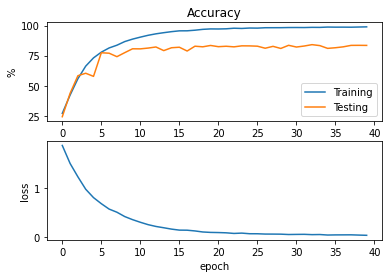

<Figure size 432x288 with 0 Axes>

In [3]:
# choose a optimizer
if optimizer.upper() == 'ADAM':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer.upper() == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# compile the model, prepare to train
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False: output layer is already softmax
    metrics=['accuracy']
)

# training
history_training = model.fit(x_train_n, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test_n, y_test))

# save model
model.save_weights(model_path)

# plot
training_accuracy = np.array(history_training.history['accuracy']) * 100
training_loss = history_training.history['loss']
testing_accuracy = np.array(history_training.history['val_accuracy']) * 100

plt.figure('Accuracy and Loss')
plt.subplot(2, 1, 1)
plt.title('Accuracy')
plt.plot(training_accuracy, label='Training')
plt.plot(testing_accuracy, label = 'Testing')
plt.ylabel('%')
plt.legend(loc='lower right')
plt.subplot(2, 1, 2)
plt.plot(training_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
t = time.localtime()
plt.savefig('images/history_' + time.strftime("%Y%m%d_%H%M%S", t) + '.png')